<a href="https://colab.research.google.com/github/Ravimk07/Tensorflow_colab_examples/blob/master/Test_segmentation_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import zipfile
import functools

In [0]:
# load the data by uploding on drive
os.getcwd()

'/content'

In [3]:
from google.colab import files
uploaded = files.upload()

Saving patches_256x256.zip to patches_256x256.zip


In [5]:
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print('Saved file', name)

Saved file patches_256x256.zip


In [0]:
os.listdir('/content/')

['.config', 'patches_256x256.zip', 'sample_data']

In [0]:

# This is for extracting the files
import zipfile
path_to_zip_file = 'patches_256x256.zip'
directory_to_extract_to = ''
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()

In [0]:
os.listdir('/content/')

['.config', 'patches_256x256.zip', 'patches_256x256', 'sample_data']

In [7]:

os.listdir('/content/patches_256x256')

['gt', 'images']

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
path_train = '/content/patches_256x256' 
im_height = 256
im_width = 256

In [10]:
def get_data(path, train=True):
    ids = glob.glob(os.path.join(path, "images", '*.jpg'))
    ids = [os.path.basename(i)[:-4] for i in ids] 
    X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        x_img = imread(os.path.join(path, 'images', id_ + '.jpg'))
        #x_img = img.pixel_array
        x_img = resize(x_img, (256, 256, 3), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(os.path.join(path, 'gt', id_ + '.png'), grayscale=True))
            mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., :] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [0]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization

In [0]:
def conv_block(model, dim, activation = 'relu', batch_norm = 'True', residual = 'True', drate = 0.5):
	n = Conv2D(dim, 3, activation = activation, padding='same', kernel_initializer = 'he_normal')(model)
	n = BatchNormalization()(n) if batch_norm else n
	n = Dropout(drate)(n) if drate else n
	n = Conv2D(dim, 3, activation = activation, padding='same', kernel_initializer = 'he_normal')(n)
	n = BatchNormalization()(n) if batch_norm else n
	return Concatenate()([model, n]) if residual else n

def level_block(model, dim, depth, inc, acti, drate, batch_norm, maxpool, upconv, residual):
	if depth > 0:
		n = conv_block(model, dim, acti, batch_norm, residual)
		model = MaxPooling2D()(n) if maxpool else Conv2D(dim, 3, strides=2, padding='same')(n)
		model = level_block(model, int(inc*dim), depth-1, inc, acti, drate, batch_norm, maxpool, upconv, residual)
		if upconv:
			model = UpSampling2D()(model)
			model = Conv2D(dim, 2, activation=acti, padding='same', kernel_initializer = 'he_normal')(model)
		else:
			model = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same', kernel_initializer = 'he_normal')(model)
		n = Concatenate()([n, model])
		model = conv_block(n, dim, acti, batch_norm, residual)
	else:
		model = conv_block(model, dim, acti, batch_norm, residual, drate)
	return model

def UNet(img_shape, out_ch = 1, start_ch = 64, depth = 4, inc_rate = 2, activation = 'relu', 
		 dropout = 0.5, batchnorm = True, maxpool = True, upconv = True, residual = True):
	i = Input(shape = img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

model = UNet((256, 256, 3), out_ch = 1, start_ch = 64, depth = 5, inc_rate = 2, activation = 'relu',
             dropout = 0.5, batchnorm = True, maxpool = True, upconv = True, residual = True)

In [13]:
import gc
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=2019)
del(X)
del(y)
gc.collect()

14

In [14]:
print(X_train.shape)
print(X_valid.shape)

(791, 256, 256, 3)
(340, 256, 256, 3)


In [15]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy', dice_coef_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from keras.callbacks import TensorBoard

callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/ravi_model-tgs-salt-dropout0.5-diceloss.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='/content/logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True)
]

In [17]:
results = model.fit(X_train, y_train, batch_size=2, epochs=50, callbacks=callbacks, shuffle = True,
                   validation_data=(X_valid, y_valid))

Train on 791 samples, validate on 340 samples
Epoch 1/50
791/791 [==============================] - 578s 730ms/step - loss: 0.6152 - acc: 0.0000e+00 - dice_coef_loss: 0.0264 - val_loss: 2.1382 - val_acc: 0.0000e+00 - val_dice_coef_loss: 0.0713

Epoch 00001: val_loss improved from inf to 2.13816, saving model to /content/ravi_model-tgs-salt-dropout0.5-diceloss.h5
Epoch 2/50
791/791 [==============================] - 557s 704ms/step - loss: 0.4880 - acc: 0.0000e+00 - dice_coef_loss: 0.0120 - val_loss: 1.2213 - val_acc: 0.0000e+00 - val_dice_coef_loss: 0.0444

Epoch 00002: val_loss improved from 2.13816 to 1.22133, saving model to /content/ravi_model-tgs-salt-dropout0.5-diceloss.h5
Epoch 3/50
791/791 [==============================] - 557s 704ms/step - loss: 0.4741 - acc: 0.0000e+00 - dice_coef_loss: 0.0089 - val_loss: 1.6506 - val_acc: 0.0000e+00 - val_dice_coef_loss: 0.0789

Epoch 00003: val_loss did not improve from 1.22133
Epoch 4/50
791/791 [==============================] - 559s 706

KeyboardInterrupt: ignored

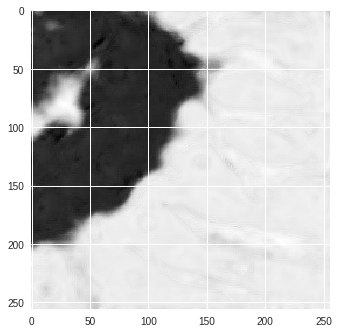

In [29]:
plt.imshow(model.predict(X_valid[30].reshape(1, 256, 256, 3))[0,:,:,0], cmap='gray')

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


TypeError: ignored

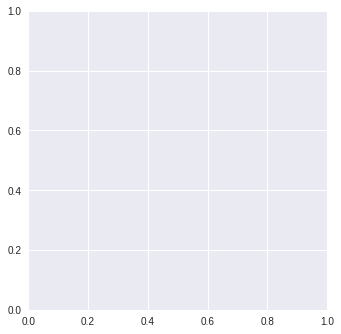

In [37]:
temp = model.predict(X_valid[30].reshape((1, 256, 256, 3)))
imshow(temp.reshape((256, 256, 1)))
imshow(X_valid[30].reshape((256, 256, 3)))
imshow(y_valid[30].reshape((256, 256, 1)))